In [1]:
from sklearn.model_selection import train_test_split
from mxnet import autograd,gluon,init,nd
from mxnet.gluon import nn
from collections import Counter
from sklearn.metrics import accuracy_score
from mxnet.gluon.data.vision import transforms

import mxnet as mx
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt


In [2]:
# define the input path and file
data_dir = '../data'
output_dir = '../outputs'
model_dir = '../model'
x_file = 'image-train.txt'
y_file = 'label-train.txt'
params_file = 'lenet.params'
test_file = 'test-data.txt'
output2_file = 'y2.out'

In [3]:
# initialize hyper parameter
lr,num_epochs,batch_size,dropout,ctx = 0.001, 80, 128, 0.4,mx.gpu()

In [4]:
def load_data(data_dir,x_file,y_file):
    """
    Load the training data 
    Input: directory of data, filename of training image, filename of training label
    Output: dataset X in 3D shape, label
    """
    # load the data into data frame
    x = pd.read_csv(os.path.join(data_dir, x_file), sep=" ", header=None)
    y = pd.read_csv(os.path.join(data_dir, y_file), sep=" ", header=None)
    
    # num_data
    num_data = len(x)
    
    # transform the data into ndarray
    X = x.iloc[:, :].astype(int).values
    # define the size of one picture
    size = np.sqrt(X.shape[1]).astype(int)
    image_shape = (size,size)

    X = X.reshape((-1,size,size,1))

    Y = y.iloc[:, :].astype(int).values
    Y = Y.reshape((num_data,)).astype(np.float32)
    
    print("The shape of X is: %s" % str(X.shape))
    print("The shape of Y is: %s" % str(Y.shape))
    return X,Y

In [5]:
def Array2Data(x_array,y_array,batch_size=128,isTrain=False):
    """
    Transform the raw data to the format of data in gluon
    Input: training images, training labels, batch size, flag for training(can be used for train or test)
    Output: data for training and prediction in gluon
    """
    mx_x_array = nd.array(x_array)
    mx_y_array = nd.array(y_array)
    dataset = gluon.data.dataset.ArrayDataset(mx_x_array,mx_y_array)
    
    # Converts an image NDArray of shape (H x W x C) in the range [0, 255] 
    #to a float32 tensor NDArray of shape (C x H x W) in the range [0, 1).
    transformer = transforms.ToTensor()
    gluonData = gluon.data.DataLoader(dataset.transform_first(transformer),batch_size=batch_size,shuffle=isTrain)
    
    return gluonData

In [6]:
# Build a simple convolutional network
def build_lenet(net):
    """
    Build up the structure of LeNet
    Input: neural network basic (No architecture at all)
    Output: neural network with architecture
    """
    with net.name_scope():
        # First convolution
        net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
        net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
        # Second convolution
        net.add(gluon.nn.Conv2D(channels=50, kernel_size=5, activation='relu'))
        net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
        # Flatten the output before the fully connected layers
        net.add(gluon.nn.Flatten())
        # First fully connected layers with 512 neurons
        net.add(gluon.nn.Dense(120, activation="relu"))
        net.add(gluon.nn.Dense(84, activation="relu"))
        net.add(gluon.nn.Dropout(0.1))
        # Second fully connected layer with as many neurons as the number of classes
        net.add(gluon.nn.Dense(10))

        return net


In [7]:
def plot_learningcurves(loss_tr,loss_ts, acc_tr,acc_ts):
    """
    Plot the learning curve of loss and accuracy vs epochs
    Input: loss and accuracy of training and validation(test)
    Output: Plot of learning curve
    """
    xs = list(range(len(loss_tr)))

    f = plt.figure(figsize=(12,6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)

    fg1.set_xlabel('epoch',fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True,which="both")

    fg1.legend(['training loss', 'validation loss'],fontsize=14)

    fg2.set_title('Comparing accuracy')
    fg2.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training accuracy', 'validation accuracy'],fontsize=14)
    

In [8]:
def evaluate_accuracy(data_iterator, net):
    """
    Calculate the accuracy and loss of a dataset
    Input: data in gluon format, model
    Output: accuracy and loss
    """
    numerator = 0.
    denominator = 0.
    loss_avg = 0.
    # Use cross entropy loss
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        loss = softmax_cross_entropy(output, label)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return (numerator / denominator).asscalar(), loss_avg


In [9]:
def train_model(model,train_data,valid_data):
    """
    Training the CNN
    Input: model, training data, validation data
    Outptu: The final loss and accuracy of training and validation set
    """
    # Initialize the parameters with Xavier initializer
    model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
    # Use cross entropy loss
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    # Use Adam optimizer
    trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': lr})

    loss_seq_train = []
    loss_seq_validation = []
    acc_seq_train = []
    acc_seq_validation = []

    
    # Train for one epoch
    for epoch in range(num_epochs+1):
        train_loss, train_acc, valid_acc = 0., 0., 0.
        # Iterate through the images and labels in the training data
        for batch_num, (data, label) in enumerate(train_data):
            # get the images and labels
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            # Ask autograd to record the forward pass
            with autograd.record():
                # Run the forward pass
                output = model(data)
                # Compute the loss
                loss = softmax_cross_entropy(output, label)
            # Compute gradients
            loss.backward()
            # Update parameters
            trainer.step(data.shape[0])
        
        validation_accuracy, validation_loss = evaluate_accuracy(valid_data, net)
        train_accuracy, train_loss = evaluate_accuracy(train_data, net)
        # save them for later
        loss_seq_train.append(train_loss)
        loss_seq_validation.append(validation_loss)
        acc_seq_train.append(train_accuracy)
        acc_seq_validation.append(validation_accuracy)

        if epoch % 2 == 0:
            curr_loss = nd.mean(loss).asscalar()
            print("Epoch: %d; Train Loss %f,Train_accuracy %f,Validation Loss %f, Valid_accuracy %f" % (epoch,train_loss,train_accuracy,validation_loss,validation_accuracy))
    
    ## Plotting the learning curves
    plot_learningcurves(loss_seq_train,loss_seq_validation,acc_seq_train,acc_seq_validation)
    plt.savefig(os.path.join(output_dir,'learning_curve.png'))
    
    return train_loss,validation_loss,train_accuracy,validation_accuracy

In [10]:
def output_pred(output_dir,filename,error,pred_vec):
    """
    Output the prediction
    Input: Directory of output, filename of output, training error, prediction of test set
    Output: file including classification error and predition of test set
    """
    output_path = os.path.join(output_dir, filename)
    with open(output_path,"w") as fd:
        fd.write('%f\n' % error)
        for pred in pred_vec:
            fd.write('%d\n' % pred.astype(np.int32))
    print("Finish output!")

In [11]:
# Load in the data and transformation to proper format
X,Y = load_data(data_dir,x_file,y_file)

train_X,valid_X,train_Y,valid_Y = train_test_split(X,Y,test_size = 0.05, shuffle = True,random_state=42)
train_data = Array2Data(train_X,train_Y,isTrain=True)
valid_data = Array2Data(valid_X,valid_Y)

The shape of X is: (40000, 28, 28, 1)
The shape of Y is: (40000,)


Epoch: 0; Train Loss 0.455805,Train_accuracy 0.833263,Validation Loss 0.450884, Valid_accuracy 0.833000
Epoch: 2; Train Loss 0.314073,Train_accuracy 0.885447,Validation Loss 0.328436, Valid_accuracy 0.878500
Epoch: 4; Train Loss 0.260674,Train_accuracy 0.901711,Validation Loss 0.284510, Valid_accuracy 0.894000
Epoch: 6; Train Loss 0.209960,Train_accuracy 0.923868,Validation Loss 0.248799, Valid_accuracy 0.912500
Epoch: 8; Train Loss 0.175595,Train_accuracy 0.934737,Validation Loss 0.230075, Valid_accuracy 0.916000
Epoch: 10; Train Loss 0.132863,Train_accuracy 0.954447,Validation Loss 0.203323, Valid_accuracy 0.931000
Epoch: 12; Train Loss 0.106964,Train_accuracy 0.962526,Validation Loss 0.198296, Valid_accuracy 0.931000
Epoch: 14; Train Loss 0.088070,Train_accuracy 0.970237,Validation Loss 0.199544, Valid_accuracy 0.941500
Epoch: 16; Train Loss 0.072043,Train_accuracy 0.975079,Validation Loss 0.204816, Valid_accuracy 0.935000
Epoch: 18; Train Loss 0.054483,Train_accuracy 0.982421,Valid

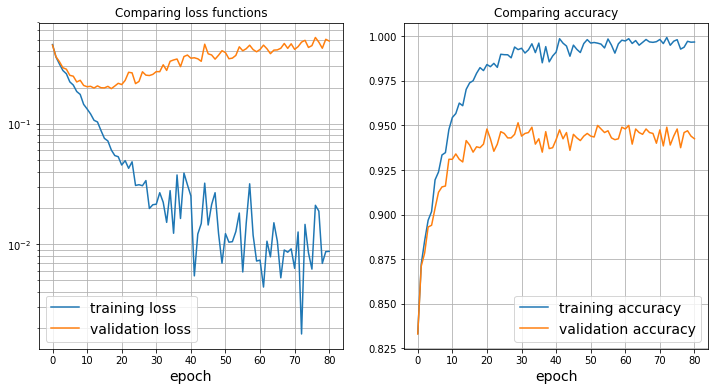

In [12]:
# Build up model and begin training
net = build_lenet(gluon.nn.Sequential())
train_loss,validation_loss,train_accuracy,valid_accuracy = train_model(net,train_data,valid_data)


In [106]:
# Calculate the classifcation error

train_error = 1- train_accuracy
validation_error = 1 - valid_accuracy
print(train_error)
print(validation_error)

In [113]:
# save model parameters to file
net.save_params(os.path.join(model_dir, params_file))

In [37]:
# Load in test set and preprocessing

test = pd.read_csv(os.path.join(data_dir, test_file), sep=" ", header=None)
# transform the data into ndarray
test_X = test.iloc[:, :].astype(int).values
num_sample = test_X.shape[0]
# construct a trivial label vector for construction of data in gluon format
test_Y = np.ones(num_sample)

size = np.sqrt(test_X.shape[1]).astype(int)
image_shape = (size,size)
test_X = test_X.reshape((-1,size,size,1))
test_data = Array2Data(test_X,test_Y,batch_size=num_sample)

In [40]:
# Predictions on the test set
for data,label in test_data:
    out = net(data.as_in_context(ctx))
    test_pred = nd.argmax(out,axis=1).asnumpy()
    print(test_pred)

[2. 2. 5. ... 9. 1. 1.]


In [41]:
# Output the predictions and training error
output_pred(output_dir,output2_file,train_error,test_pred)

Finish output!
